In [2]:
import torch
import os
from torch import linalg as LA
import numpy as np
print(torch.cuda.is_available())

True


In [4]:
device='cuda' 


# Define network parameters
W1 = torch.randn(20, 10, requires_grad=True)
b1 = torch.randn(20, 1, requires_grad=True)
W2 = torch.randn(20, 1, requires_grad=True)
b2 = torch.randn(1, requires_grad=True)

# Define forward pass function
def forward(x):
    z = torch.matmul(W1, x) + b1
    a = torch.tanh(z)
    y_hat = torch.matmul(W2.T, a) + b2
    return y_hat

# Define loss function
def loss(y_hat, y):
    return torch.mean(torch.abs(y_hat - y))

# Generate random input and output data
x = torch.randn(100, 10, 1)
y = torch.randn(100, 1, 1)

# Compute forward pass and loss
y_hat = forward(x)
L = loss(y_hat, y)

# Compute gradients with autograd
L.backward()
auto_W1 = W1.grad
auto_b1 = b1.grad
auto_W2 = W2.grad
auto_b2 = b2.grad

# Compute gradients manually
hand_b2 = torch.mean(torch.sign(y_hat - y), dim=0)
hand_W2 = torch.mean(torch.sign(y_hat - y) * torch.tanh(torch.matmul(W1, x) + b1), dim=0)
hand_b1 = torch.mean(torch.sign(y_hat - y) * W2 * (1 - torch.tanh(torch.matmul(W1, x) + b1) ** 2), dim=0)
hand_W1 = torch.mean(torch.matmul(torch.sign(y_hat - y) * W2 * (1 - torch.tanh(torch.matmul(W1, x) + b1) ** 2), x.permute(0, 2, 1)), dim=0)


# Compare gradients
print('W1 diff:', torch.linalg.norm(auto_W1 - hand_W1))
print('b1 diff:', torch.linalg.norm(auto_b1 - hand_b1))
print('W2 diff:', torch.linalg.norm(auto_W2 - hand_W2))
print('b2 diff:', torch.linalg.norm(auto_b2 - hand_b2))



W1 diff: tensor(1.1259e-07, grad_fn=<LinalgVectorNormBackward0>)
b1 diff: tensor(2.8958e-08, grad_fn=<LinalgVectorNormBackward0>)
W2 diff: tensor(1.3286e-07, grad_fn=<LinalgVectorNormBackward0>)
b2 diff: tensor(2.9802e-08, grad_fn=<LinalgVectorNormBackward0>)


In [5]:
# Train this model on the sklearn California Housing Prices datasets.
# • For this you may use the optimizer and learning rates of your choice and train
# for 20-50 epochs.
# • Take half the data for training and half for testing.
# • Create a validation set from the training set and use it to select a good learning
# rate.
# • You might want to use the convenient Xavier initialization.
# • You are free to use the torch.optim package for this part.
# • To speed up things, run the training loop by batches (e.g. 4, 8, 32, 64, etc.).
# PyTorch’s DataLoader would be a useful tool to easily fetch a predefined set
# of batches per training iteration.
# • Report the mean squared error on the train and test set after each epoch.
# • You will need to adjust the size of W 1 to fit the size of this data.

# Load the data
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import numpy as np

data = fetch_california_housing()
X = data['data']
y = data['target']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Normalize the data
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)

# Convert to torch tensors
X_train = torch.from_numpy(X_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

# Define the network
class MyNet(torch.nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.linear1 = torch.nn.Linear(8, 20)
        self.linear2 = torch.nn.Linear(20, 1)
        self.tanh = torch.nn.Tanh()
    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        return x
    
# Define the loss function
def my_loss(y_hat, y):
    return torch.mean(torch.abs(y_hat - y))

# Define the training loop
def train_loop(model, input, target, num_epochs=50, learning_rate=1e-3):
    for epoch in range(num_epochs):
        y_hat = model(input)
        loss = my_loss(y_hat, target)
        loss.backward()
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad
                param.grad.zero_()
        if epoch % 5 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return model

# Train the network
model = MyNet().to(device)
model = train_loop(model, X_train, y_train)

# Evaluate the network
y_hat = model(X_test)
loss = my_loss(y_hat, y_test)
print('Test loss: %f' % loss)



Epoch 0, Loss 2.163523
Epoch 5, Loss 2.154351
Epoch 10, Loss 2.145171
Epoch 15, Loss 2.135983
Epoch 20, Loss 2.126787
Epoch 25, Loss 2.117583
Epoch 30, Loss 2.108370
Epoch 35, Loss 2.099148
Epoch 40, Loss 2.089918
Epoch 45, Loss 2.080679
Test loss: 2.079541


In [19]:
# question 2 
# Consider the neural network
# f(x) = WF ρ ◦ WL . . . ρ ◦ Wi . . . ρ ◦ W2ρ ◦ W1x
# where W1 is K × D, Wi
# is K × K for i > 1, and WF is P × K. Note f : RD → RP .
# Take ρ(x) = tanh(x). We will examine different ways to compute the Jacobian ∂f(x)/∂x .
# (a) 
# Use torch tensors to write a function which computes the Jacobian,
# ∂f(x)/∂x , using backward mode automatic differentiation for a given value of x and
# W1, . . . , Wi, . . . , WF where the given matrices are specified by a dictionary of torch
# tensors. Implement and test this for L = 3. Your function should only make use
# of basic matrix operations (e.g. torch.matmul(), torch.tanh(), etc). You may not
# use autograd or autograd.jacobian for your implementation (but you can use them
# to unit test your answer). Test it for the case of D = 2, K = 30, P = 10, your
# solution does not have to cover all edge cases of K, P,D it is sufficient it works on
# the ones provided here.

# Define the network
def my_nn(x, param_dict):
    for i in range(1, L):
        x = torch.matmul(param_dict['W' + str(i)], x)
        x = torch.tanh(x)
    x = torch.matmul(param_dict['WF'], x)
    return x

# Define the Jacobian function by hand
def my_jacobian(x, param_dict):
    y = my_nn(x, param_dict) # forward pass
    J = torch.zeros(y.shape[0], x.shape[0])
    for i in range(y.shape[0]):
        y[i].backward(retain_graph=True)
        J[i, :] = x.grad
        x.grad.zero_()
    return J

# Define the parameters
D = 2
K = 30
P = 10
L = 10
param_dict = {}
param_dict['W1'] = torch.randn(K, D, device=device, requires_grad=True)
for i in range(2, L):
    param_dict['W' + str(i)] = torch.randn(K, K, device=device, requires_grad=True)
param_dict['WF'] = torch.randn(P, K, device=device, requires_grad=True)

# Define the input
x = torch.randn(D, device=device, requires_grad=True)

# Compute the Jacobian
J = my_jacobian(x, param_dict)
print(J)

# Compare with autograd
x = x.reshape(-1, 1)
y = my_nn(x, param_dict)
y = y.reshape(-1, 1)
J_autograd = torch.autograd.functional.jacobian(lambda x: my_nn(x, param_dict), x)
print(J)


tensor([[-18.9037,   1.2831],
        [ 15.4431,   4.1503],
        [ 18.1970,   3.9493],
        [-18.6438,  -2.3998],
        [-49.7152,  -4.7734],
        [-13.7002,  -2.1353],
        [-27.7332,  -6.0099],
        [ 12.9021,   1.2975],
        [-10.5956,  -2.8040],
        [  8.9730,  -1.3980]])
tensor([[-18.9037,   1.2831],
        [ 15.4431,   4.1503],
        [ 18.1970,   3.9493],
        [-18.6438,  -2.3998],
        [-49.7152,  -4.7734],
        [-13.7002,  -2.1353],
        [-27.7332,  -6.0099],
        [ 12.9021,   1.2975],
        [-10.5956,  -2.8040],
        [  8.9730,  -1.3980]])


torch.Size([2])
torch.Size([30, 2])
torch.Size([30])
torch.Size([30, 30])
tensor([[-3.6832,  3.1388],
        [ 2.1358, -3.0074],
        [-5.7035,  3.5083],
        [ 4.5243, -3.9619],
        [ 3.4845, -4.2608],
        [-1.6215,  1.7399],
        [ 2.4567, -0.5928],
        [ 5.4941, -5.6483],
        [ 0.4993,  1.7094],
        [-5.2610,  3.5687]])


In [ ]:
# (c) (4 points) Benchmark the Jacobian computation of (b) compared to that of (c)
# for L=3,5,10. Report speed of these answers on test cases using GPU and CPU



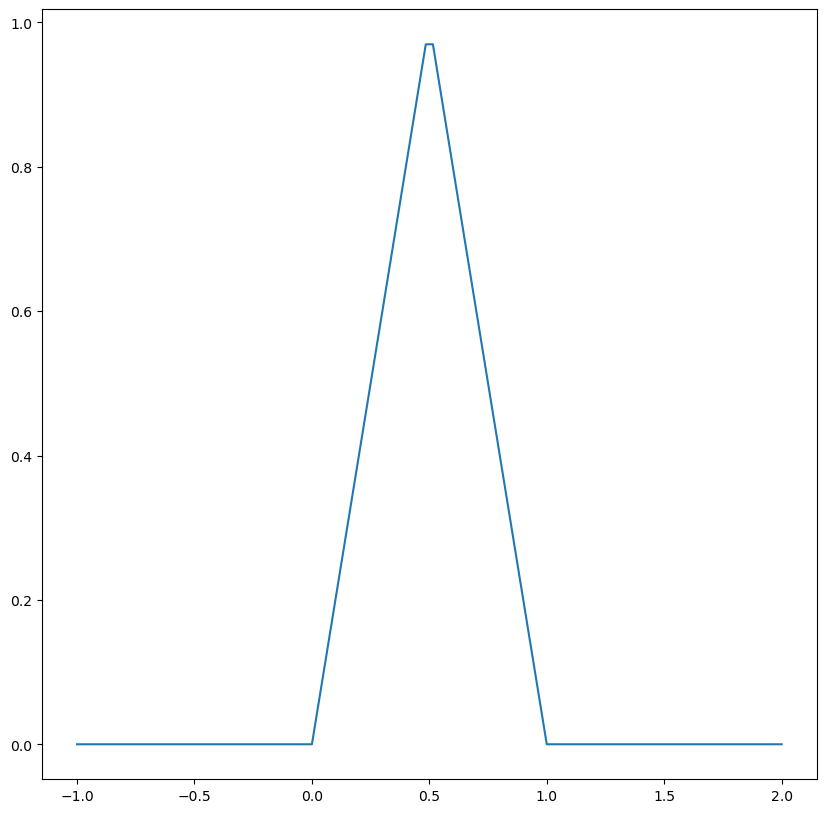

In [18]:
# 3(a)
import matplotlib.pyplot as plt
def my_fun(x):
    if x>0 and x<=0.5:
        return 2*x
    elif x>=0.5 and x<=1:
        return 2*(1-x)
    else:
        return 0

fig, axs = plt.subplots(1,1,figsize=(10,10))
x=np.linspace(-1,2,100)
y=[]
for i in x:
    y.append(my_fun(i))
axs.plot(x, y)

# For the following functions find by hand the parameters of a neural network that can
# fit these functions. You should use either a 1 or 2 hidden layer network and may use
# either sigmoid or ReLU non-linearities. In each case justify your answer and how you
# arrived at it (without using numerical/software packages).


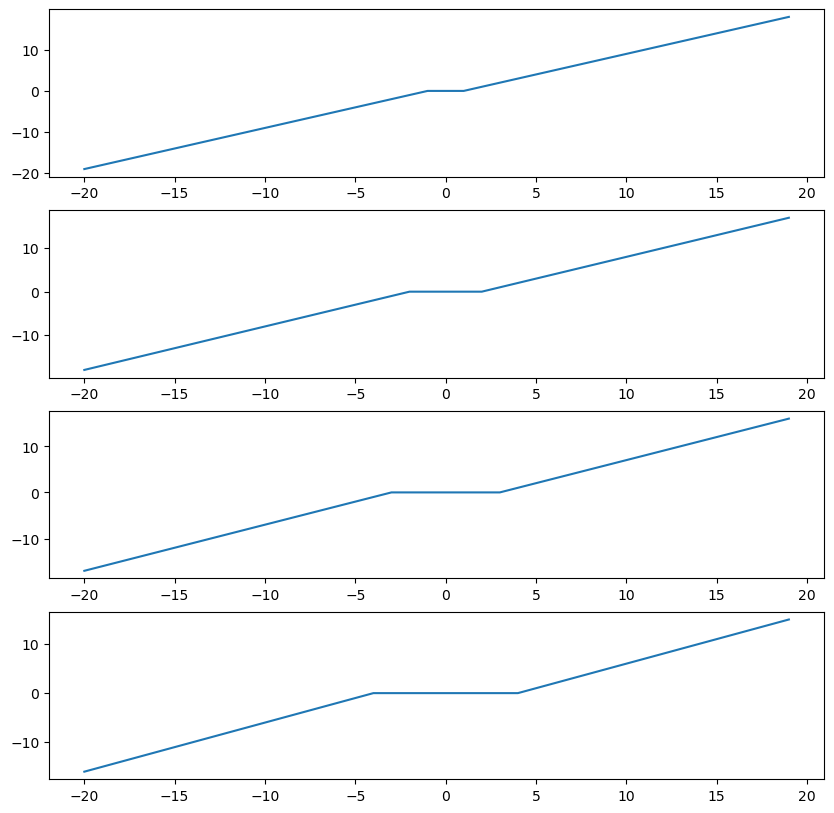

In [11]:
import math
def my_fun(x,s):
    return max(abs(x)-s,0)*math.copysign(1, x)

start=20
x=range(-1*start,start)

s=[1,2,3,4]
fig, axs = plt.subplots(4,figsize=(10,10))
for z in s:
    y=[]
    for i in x:
        y.append(my_fun(i,z))
    axs[z-1].plot(x, y,label="s="+str(z)+",x=[-"+str(start)+","+str(start)+"]")
    